In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
import json
import pickle
from pprint import pprint
import matplotlib

from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole

import seaborn as sns
from mpl_toolkits import mplot3d
# import plotly.express as px
sns.set_style("whitegrid")

In [6]:
from guacamol.standard_benchmarks import *

In [11]:
def get_benchmarks(task):
    if task == 'wo':
        bench = {
            'C7H8N2O2': isomers_c7h8n2o2(),
            'CNS MPO': cns_mpo(),
            'Pioglitazone MPO': pioglitazone_mpo(),
            'QED': qed_benchmark()
        }
    elif task == 'wa':
        bench = {
            'SA_isomer': isomers_c7h8n2o2(),
            'SA_CNS': cns_mpo(),
            'SA_pioglitazone': pioglitazone_mpo(),
            'SA_QED': qed_benchmark()
        }
    elif task == 'wc':
        bench = {
            'SC_isomer': isomers_c7h8n2o2(),
            'SC_CNS': cns_mpo(),
            'SC_pioglitazone': pioglitazone_mpo(),
            'SC_QED': qed_benchmark()
        }
    elif task == 'v3':
        bench = {
            'SA_logP_target': logP_benchmark(target=8),
            'SA_osimertinib': hard_osimertinib(),
            'SA_fexofenadine': hard_fexofenadine(),
            'SA_Ranolazine': ranolazine_mpo(),
            'SA_perindopril': perindopril_rings(),
            'SA_amlodipine': amlodipine_rings(),
            'SA_sitagliptin': sitagliptin_replacement(),
            'SA_zaleplon': zaleplon_with_other_formula(),
            'SA_valsartan': valsartan_smarts(),
            'SA_decoration_hop': scaffold_hop(),
            'SA_scaffold_hop': decoration_hop()
        }
    elif task == 'v4':
        bench = {
            'Osimertinib MPO': hard_osimertinib(),
            'Fexofenadine MPO': hard_fexofenadine(),
            'Ranolazine MPO': ranolazine_mpo(),
            'Perindopril MPO': perindopril_rings(),
            'Amlodipine MPO': amlodipine_rings(),
            'Sitagliptin MPO': sitagliptin_replacement(),
            'Zaleplon MPO': zaleplon_with_other_formula(),
            'Valsartan SMARTS': valsartan_smarts(),
            'Deco Hop': scaffold_hop(),
            'Scaffold Hop': decoration_hop()
        }
    elif task == 'v5':
        bench = {
            'SC_logP_target': logP_benchmark(target=8),
            'SC_osimertinib': hard_osimertinib(),
            'SC_fexofenadine': hard_fexofenadine(),
            'SC_Ranolazine': ranolazine_mpo(),
            'SC_ranolazine': ranolazine_mpo(),
            'SC_perindopril': perindopril_rings(),
            'SC_amlodipine': amlodipine_rings(),
            'SC_sitagliptin': sitagliptin_replacement(),
            'SC_zaleplon': zaleplon_with_other_formula(),
            'SC_valsartan': valsartan_smarts(),
            'SC_decoration_hop': scaffold_hop(),
            'SC_scaffold_hop': decoration_hop()
        }
    return bench


def normal(a):
    if a == 'SC_osimertinib' or a == 'SA_osimertinib':
        return 'Osimertinib MPO'
    elif a == 'SC_fexofenadine' or a == 'SA_fexofenadine':
        return 'Fexofenadine MPO'
    elif a == 'SC_ranolazine' or a == 'SA_Ranolazine':
        return 'Ranolazine MPO'
    elif a == 'SC_perindopril' or a == 'SA_perindopril':
        return 'Perindopril MPO'
    elif a == 'SC_amlodipine' or a == 'SA_amlodipine':
        return 'Amlodipine MPO'
    elif a == 'SC_sitagliptin' or a == 'SA_sitagliptin':
        return 'Sitagliptin MPO'
    elif a == 'SC_zaleplon' or a == 'SA_zaleplon':
        return 'Zaleplon MPO'
    elif a == 'SC_valsartan' or a == 'SA_valsartan':
        return 'Valsartan SMARTS'
    elif a == 'SC_decoration_hop' or a == 'SA_decoration_hop':
        return 'Deco Hop'
    elif a == 'SC_scaffold_hop' or a == 'SA_scaffold_hop':
        return 'Scaffold Hop'
    elif a == 'SC_CNS' or a == 'SA_CNS':
        return 'CNS MPO'
    elif a == 'SC_isomer' or a == 'SA_isomer':
        return 'C7H8N2O2'
    elif a == 'SC_pioglitazone' or a == 'SA_pioglitazone':
        return 'Pioglitazone MPO'
    elif a == 'SC_QED' or a == 'SA_QED':
        return 'QED'
    else:
        return a
    

def calc_prop(df, task):
    df['objective'] = 0
    dfs = []
    props = set(df['property'])
    benchs = get_benchmarks(task)
    for prop in props:
        bench = benchs[prop]
        df_temp = df[df['property'] == prop]
        df_temp['objective'] = df_temp.SMILES.apply(bench.objective.score)
        dfs.append(df_temp)
    return pd.concat(dfs)

def calc_avg(df, threshold, x1, x2):
    x1_candidate = list(set(df[x1]))
    x2_candidate = list(set(df[x2]))
    data = np.zeros([len(x1_candidate), len(x2_candidate)])
    df_temp = df[df['rank'] <= threshold]
    for i in range(len(x1_candidate)):
        for j in range(len(x2_candidate)):
            data[i][j] = df_temp[df_temp[x1] == x1_candidate[i]][df_temp[x2] == x2_candidate[j]].objective.mean()
            
    return pd.DataFrame(data, columns=x2_candidate, index=x1_candidate)

def make_synth_data(df, x1='property', x2='method'):
    df_synth = df[df['tb_synthesizability'] == 1]
    x1_candidate = list(set(df[x1]))
    x2_candidate = list(set(df[x2]))
    dfs = []
    for i in range(len(x1_candidate)):
        for j in range(len(x2_candidate)):
            df_temp = df_synth[df_synth[x1] == x1_candidate[i]][df_synth[x2] == x2_candidate[j]]
            df_temp['rank'] = list(range(1, len(df_temp) + 1))
            dfs.append(df_temp)
    return pd.concat(dfs)

In [6]:
temp = df_hard_mwo[df_hard_mwo['property'] == 'Deco Hop'][df_hard_mwo['method'] == 'best_from_chembl']
temp

NameError: name 'df_hard_mwo' is not defined

In [ ]:
# 'Osimertinib MPO': hard_osimertinib(),
# 'Fexofenadine MPO': hard_fexofenadine(),
# 'Ranolazine MPO': ranolazine_mpo(),
# 'Perindopril MPO': perindopril_rings(),
# 'Amlodipine MPO': amlodipine_rings(),
# 'Sitagliptin MPO': sitagliptin_replacement(),
# 'Zaleplon MPO': zaleplon_with_other_formula(),
# 'Valsartan SMARTS': valsartan_smarts(),
# 'Deco Hop': decoration_hop(),
# 'Scaffold Hop': scaffold_hop()

In [7]:
df_chembl_wo = pd.read_csv('./chembl_wo.csv')
df_chembl_wa = pd.read_csv('./chembl_wa.csv')
df_chembl_wc = pd.read_csv('./chembl_wc.csv')

df_moses_wo = pd.read_csv('./moses_wo.csv')
df_moses_wa = pd.read_csv('./moses_wa.csv')
df_moses_wc = pd.read_csv('./moses_wc.csv')

In [5]:
# df_chembl_wo['rank'] = list(range(1, 101)) * 16
# df_chembl_wa['rank'] = list(range(1, 101)) * 16
# df_chembl_wc['rank'] = list(range(1, 101)) * 16

# df_moses_wo['rank'] = list(range(1, 101)) * 16
# df_moses_wa['rank'] = list(range(1, 101)) * 16
# df_moses_wc['rank'] = list(range(1, 101)) * 16

In [6]:
# df_chembl_wo.to_csv('./chembl_wo.csv', index=False)
# df_chembl_wa.to_csv('./chembl_wa.csv', index=False)
# df_chembl_wc.to_csv('./chembl_wc.csv', index=False)

# df_moses_wo.to_csv('./moses_wo.csv', index=False)
# df_moses_wa.to_csv('./moses_wa.csv', index=False)
# df_moses_wc.to_csv('./moses_wc.csv', index=False)

In [7]:
# df_chembl_wo = calc_prop(df_chembl_wo, 'wo')
# df_chembl_wa = calc_prop(df_chembl_wa, 'wa')
# df_chembl_wc = calc_prop(df_chembl_wc, 'wc')

# df_moses_wo = calc_prop(df_moses_wo, 'wo')
# df_moses_wa = calc_prop(df_moses_wa, 'wa')
# df_moses_wc = calc_prop(df_moses_wc, 'wc')

In [8]:
df_chembl_wo_prop = calc_avg(df_chembl_wo, 100, 'property', 'method')
df_chembl_wa_prop = calc_avg(df_chembl_wa, 100, 'property', 'method')
df_chembl_wc_prop = calc_avg(df_chembl_wc, 100, 'property', 'method')

df_moses_wo_prop = calc_avg(df_moses_wo, 100, 'property', 'method')
df_moses_wa_prop = calc_avg(df_moses_wa, 100, 'property', 'method')
df_moses_wc_prop = calc_avg(df_moses_wc, 100, 'property', 'method')

In [9]:
df_moses_wo_prop, df_moses_wa_prop, df_moses_wc_prop

(                  best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 Pioglitazone MPO          0.862957     0.985188  0.980221   0.995901
 QED                       0.948295     0.948312  0.948295   0.948295
 C7H8N2O2                  0.826730     0.905177  0.912204   0.832357
 CNS MPO                   1.000000     1.000000  1.000000   1.000000,
                  best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 SA_pioglitazone          0.811770     0.981146  0.847762   0.820748
 SA_QED                   0.948166     0.948241  0.948166   0.948173
 SA_CNS                   1.000000     1.000000  1.000000   1.000000
 SA_isomer                0.811008     0.906741  0.888421   0.821447,
                  best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 SC_QED                   0.947881     0.948249  0.947893   0.947882
 SC_pioglitazone          0.746501     0.976589  0.982779   0.822324
 SC_isomer                0.824736     0.904118  0.860311   0.834238
 SC_CNS                   1

In [10]:
df_chembl_wo_prop, df_chembl_wa_prop, df_chembl_wc_prop

(                  smiles_lstm  graph_ga  best_from_chembl  smiles_ga
 Pioglitazone MPO     0.986005  0.996578          0.964301   0.999200
 CNS MPO              1.000000  1.000000          1.000000   1.000000
 QED                  0.948071  0.947820          0.947814   0.947830
 C7H8N2O2             1.000000  0.993334          0.972048   0.992099,
                  smiles_lstm  graph_ga  best_from_chembl  smiles_ga
 SA_pioglitazone     0.941793  0.876173          0.861828   0.879976
 SA_QED              0.947949  0.947366          0.947356   0.947383
 SA_isomer           1.000000  0.945904          0.944729   0.952896
 SA_CNS              1.000000  1.000000          1.000000   1.000000,
                  smiles_lstm  graph_ga  best_from_chembl  smiles_ga
 SC_isomer           1.000000  0.974867          0.966127   0.966832
 SC_pioglitazone     0.951539  0.974329          0.904147   0.942912
 SC_CNS              1.000000  1.000000          1.000000   1.000000
 SC_QED              0.9479

In [11]:
df_chembl_wo_synth = make_synth_data(df_chembl_wo)
df_chembl_wa_synth = make_synth_data(df_chembl_wa)
df_chembl_wc_synth = make_synth_data(df_chembl_wc)

df_moses_wo_synth = make_synth_data(df_moses_wo)
df_moses_wa_synth = make_synth_data(df_moses_wa)
df_moses_wc_synth = make_synth_data(df_moses_wc)

In [12]:
df_chembl_wo_prop_s10 = calc_avg(df_chembl_wo_synth, 10, 'property', 'method')
df_chembl_wa_prop_s10 = calc_avg(df_chembl_wa_synth, 10, 'property', 'method')
df_chembl_wc_prop_s10 = calc_avg(df_chembl_wc_synth, 10, 'property', 'method')

df_moses_wo_prop_s10 = calc_avg(df_moses_wo_synth, 10, 'property', 'method')
df_moses_wa_prop_s10 = calc_avg(df_moses_wa_synth, 10, 'property', 'method')
df_moses_wc_prop_s10 = calc_avg(df_moses_wc_synth, 10, 'property', 'method')

In [13]:
df_moses_wo_prop_s10, df_moses_wa_prop_s10, df_moses_wc_prop_s10

(                  best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 Pioglitazone MPO          0.900289     0.990511  0.981939        NaN
 QED                       0.948397     0.948397  0.948393   0.948397
 C7H8N2O2                  0.882497     0.923870  0.971451   0.882497
 CNS MPO                   1.000000     1.000000  1.000000   1.000000,
                  best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 SA_pioglitazone          0.868506     0.991913  0.951067   0.878039
 SA_QED                   0.948320     0.948387  0.948320   0.948344
 SA_CNS                   1.000000     1.000000  1.000000   1.000000
 SA_isomer                0.882497     0.923870  0.923870   0.882497,
                  best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 SC_QED                   0.948298     0.948383  0.948298   0.948298
 SC_pioglitazone          0.855607     0.986704  0.984961   0.873004
 SC_isomer                0.882497     0.933386  0.900714   0.882497
 SC_CNS                   1

In [14]:
df_chembl_wo_prop_s10, df_chembl_wa_prop_s10, df_chembl_wc_prop_s10

(                  best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 Pioglitazone MPO          0.983813     0.994383       NaN        NaN
 QED                       0.948212     0.948300  0.948212   0.948212
 C7H8N2O2                  1.000000     1.000000  1.000000   1.000000
 CNS MPO                   1.000000     1.000000  1.000000   1.000000,
                  best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 SA_pioglitazone          0.936363     0.973489  0.953875   0.939517
 SA_QED                   0.948126     0.948203  0.948126   0.948137
 SA_CNS                   1.000000     1.000000  1.000000   1.000000
 SA_isomer                1.000000     1.000000  1.000000   1.000000,
                  best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 SC_QED                   0.947857     0.948274  0.948051   0.947946
 SC_pioglitazone          0.977070     0.990574  0.979852   0.980870
 SC_isomer                1.000000     1.000000  1.000000   1.000000
 SC_CNS                   1

# Hard Goals

In [15]:
file_path = 'data/chembl_wa.csv'
df = pd.read_csv(file_path)
df['property'] = df.property.apply(normal)
df.to_csv(file_path, index=False)

file_path = 'data/chembl_wc.csv'
df = pd.read_csv(file_path)
df['property'] = df.property.apply(normal)
df.to_csv(file_path, index=False)

file_path = 'data/moses_wa.csv'
df = pd.read_csv(file_path)
df['property'] = df.property.apply(normal)
df.to_csv(file_path, index=False)

file_path = 'data/moses_wc.csv'
df = pd.read_csv(file_path)
df['property'] = df.property.apply(normal)
df.to_csv(file_path, index=False)

In [13]:
df = pd.read_csv('data/goal_hard_cwo.csv')
df = calc_prop(df, 'v4')
df['property'] = df.property.apply(normal)
df['dataset'] = 'chembl'
df['type'] = 'wo'
df.to_csv('data/goal_hard_cwo.csv', index=False)

df = pd.read_csv('data/goal_hard_cwa.csv')
df = calc_prop(df, 'v3')
df['property'] = df.property.apply(normal)
df['dataset'] = 'chembl'
df['type'] = 'wa'
df.to_csv('data/goal_hard_cwa.csv', index=False)

df = pd.read_csv('data/goal_hard_cwc.csv')
df = calc_prop(df, 'v5')
df['property'] = df.property.apply(normal)
df['dataset'] = 'chembl'
df['type'] = 'wc'
df.to_csv('data/goal_hard_cwc.csv', index=False)



df = pd.read_csv('data/goal_hard_mwo.csv')
df = calc_prop(df, 'v4')
df['property'] = df.property.apply(normal)
df['dataset'] = 'moses'
df['type'] = 'wo'
df.to_csv('data/goal_hard_mwo.csv', index=False)

df = pd.read_csv('data/goal_hard_mwa.csv')
df = calc_prop(df, 'v3')
df['property'] = df.property.apply(normal)
df['dataset'] = 'moses'
df['type'] = 'wa'
df.to_csv('data/goal_hard_mwa.csv', index=False)

df = pd.read_csv('data/goal_hard_mwc.csv')
df = calc_prop(df, 'v5')
df['property'] = df.property.apply(normal)
df['dataset'] = 'moses'
df['type'] = 'wc'
df.to_csv('data/goal_hard_mwc.csv', index=False)

In [15]:
df_hard_cwo = pd.read_csv('./goal_hard_cwo.csv')
df_hard_cwo = calc_prop(df_hard_cwo, 'v4')
df_hard_cwo['property'] = df_hard_cwo.property.apply(normal)
df_hard_cwo_prop = calc_avg(df_hard_cwo, 100, 'property', 'method')
df_hard_cwo_synth = make_synth_data(df_hard_cwo)
df_hard_cwo_prop_s10 = calc_avg(df_hard_cwo_synth, 10, 'property', 'method')
df_hard_cwo_prop, df_hard_cwo_prop_s10

(                  best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 Valsartan SMARTS          0.015936     0.873721  0.838802   0.766260
 Ranolazine MPO            0.775758     0.828646  0.900122   0.853034
 Osimertinib MPO           0.822454     0.893884  0.937169   0.877664
 Scaffold Hop              0.588835     0.999597  1.000000   0.882034
 Perindopril MPO           0.528279     0.744189  0.772750   0.643735
 Amlodipine MPO            0.665359     0.874516  0.867516   0.716947
 Deco Hop                  0.906690     0.992215  0.992857   0.935911
 Sitagliptin MPO           0.418583     0.453154  0.812724   0.523086
 Zaleplon MPO              0.510365     0.568419  0.685400   0.510385
 Fexofenadine MPO          0.773313     0.900022  0.976829   0.889327,
                   best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 Valsartan SMARTS          0.120667     0.961989  0.699917        NaN
 Ranolazine MPO            0.793950     0.842266       NaN        NaN
 Scaffold Hop      

In [16]:
df_hard_cwa = pd.read_csv('./goal_hard_cwa.csv')
df_hard_cwa = calc_prop(df_hard_cwa, 'v3')
df_hard_cwa['property'] = df_hard_cwa.property.apply(normal)
df_hard_cwa_prop = calc_avg(df_hard_cwa, 100, 'property', 'method')
df_hard_cwa_synth = make_synth_data(df_hard_cwa)
df_hard_cwa_prop_s10 = calc_avg(df_hard_cwa_synth, 10, 'property', 'method')
df_hard_cwa_prop, df_hard_cwa_prop_s10

(                  best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 Valsartan SMARTS          0.015936     0.828043  0.721992   0.405988
 Ranolazine MPO            0.695816     0.837944  0.846683   0.719544
 Osimertinib MPO           0.810687     0.874185  0.866331   0.812308
 Scaffold Hop              0.564387     0.974514  0.857905   0.578170
 Perindopril MPO           0.479667     0.574351  0.544825   0.483293
 Deco Hop                  0.899436     1.000000  0.948827   0.904375
 Amlodipine MPO            0.583404     0.790425  0.668503   0.591385
 Sitagliptin MPO           0.378961     0.460299  0.508205   0.385091
 Zaleplon MPO              0.506932     0.561878  0.640941   0.508097
 Fexofenadine MPO          0.730816     0.895169  0.886391   0.735520,
                   best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 Valsartan SMARTS          0.120667     0.966428       NaN   0.545985
 Ranolazine MPO            0.748353     0.848422  0.860392   0.773438
 Scaffold Hop      

In [17]:
df_hard_mwa = pd.read_csv('./goal_hard_mwa.csv')
df_hard_mwa = calc_prop(df_hard_mwa, 'v3')
df_hard_mwa['property'] = df_hard_mwa.property.apply(normal)
df_hard_mwa_prop = calc_avg(df_hard_mwa, 100, 'property', 'method')
df_hard_mwa_synth = make_synth_data(df_hard_mwa)
df_hard_mwa_prop_s10 = calc_avg(df_hard_mwa_synth, 10, 'property', 'method')
df_hard_mwa_prop, df_hard_mwa_prop_s10

(                  best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 Valsartan SMARTS          0.018043     0.284916  0.637462   0.479398
 Ranolazine MPO            0.259968     0.733014  0.804408   0.283861
 Osimertinib MPO           0.804416     0.857632  0.850937   0.805274
 Scaffold Hop              0.510622     0.628595  0.657563   0.512844
 Perindopril MPO           0.471479     0.592385  0.540456   0.473997
 Deco Hop                  0.805685     0.945404  0.965489   0.873575
 Amlodipine MPO            0.569193     0.692516  0.624295   0.570489
 Sitagliptin MPO           0.426928     0.480587  0.432271   0.430869
 Zaleplon MPO              0.533761     0.588384  0.536939   0.534210
 Fexofenadine MPO          0.656144     0.783185  0.838471   0.657386,
                   best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 Valsartan SMARTS          0.174960     0.730553  0.859268   0.360103
 Ranolazine MPO            0.301147     0.761119  0.822464   0.329473
 Scaffold Hop      

In [18]:
df_hard_mwo = pd.read_csv('./goal_hard_mwo.csv')
df_hard_mwo = calc_prop(df_hard_mwo, 'v4')
df_hard_mwo['property'] = df_hard_mwo.property.apply(normal)
df_hard_mwo_prop = calc_avg(df_hard_mwo, 100, 'property', 'method')
df_hard_mwo_synth = make_synth_data(df_hard_mwo)
df_hard_mwo_prop_s10 = calc_avg(df_hard_mwo_synth, 10, 'property', 'method')
df_hard_mwo_prop, df_hard_mwo_prop_s10

(                  best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 Valsartan SMARTS          0.018043     0.383731  0.648990   0.604266
 Ranolazine MPO            0.273755     0.713389  0.897242   0.840541
 Osimertinib MPO           0.806352     0.853857  0.895202   0.846173
 Scaffold Hop              0.523837     0.640842  0.879675   0.737785
 Perindopril MPO           0.489945     0.652880  0.750985   0.534619
 Amlodipine MPO            0.624308     0.779609  0.805464   0.645190
 Deco Hop                  0.809944     0.947448  0.937725   0.952386
 Sitagliptin MPO           0.444196     0.486152  0.757202   0.444262
 Zaleplon MPO              0.537056     0.583651  0.633178   0.537629
 Fexofenadine MPO          0.664158     0.839374  0.882355   0.724087,
                   best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 Valsartan SMARTS          0.174960     0.802914  0.819675   0.478437
 Ranolazine MPO            0.311792     0.726074       NaN        NaN
 Scaffold Hop      

In [19]:
df_hard_mwc = pd.read_csv('./goal_hard_mwc.csv')
df_hard_mwc = calc_prop(df_hard_mwc, 'v5')
df_hard_mwc['property'] = df_hard_mwc.property.apply(normal)
df_hard_mwc_prop = calc_avg(df_hard_mwc, 100, 'property', 'method')
df_hard_mwc_synth = make_synth_data(df_hard_mwc)
df_hard_mwc_prop_s10 = calc_avg(df_hard_mwc_synth, 10, 'property', 'method')
df_hard_mwc_prop, df_hard_mwc_prop_s10

(                  best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 Valsartan SMARTS          0.018043     0.135704  0.131144   0.023965
 Ranolazine MPO            0.205886     0.782010  0.767990   0.447890
 Osimertinib MPO           0.766550     0.849344  0.836323   0.769372
 Scaffold Hop              0.457580     0.606372  0.533443   0.458541
 Perindopril MPO           0.436786     0.604643  0.605988   0.438526
 Amlodipine MPO            0.570732     0.768582  0.734678   0.575813
 Deco Hop                  0.585112     0.928075  0.885909   0.586052
 Sitagliptin MPO           0.320806     0.426588  0.323472   0.322256
 Zaleplon MPO              0.475550     0.566461  0.480940   0.476864
 Fexofenadine MPO          0.608377     0.862974  0.833231   0.628518,
                   best_from_chembl  smiles_lstm  graph_ga  smiles_ga
 Valsartan SMARTS          0.174960     0.534448  0.403565   0.174960
 Ranolazine MPO            0.252776     0.798258       NaN        NaN
 Scaffold Hop      

In [20]:
index =  ['SA_logP_target', 'SA_osimertinib', 'SA_fexofenadine', 'SA_Ranolazine', 
                          'SA_perindopril', 'SA_amlodipine', 'SA_sitagliptin', 'SA_zaleplon',
                          'SA_valsartan', 'SA_scaffold_hop', 'SA_decoration_hop']

columns = ['best_from_chembl', 'graph_ga', 'smiles_lstm', 'smiles_ga']

In [21]:
data = [
    [1, 1, 1, 1],
    [0.839, 0.953, 0.907, 0.886],
    [0.817, 0.998, 0.959, 0.931],
    [0.792, 0.92, 0.855, 0.881],
    [0.575, 0.792, 0.808, 0.661],
    [0.696, 0.894, 0.894, 0.722],
    [0.509, 0.891, 0.545, 0.689],
    [0.547, 0.754, 0.669, 0.413],
    [0.259, 0.99, 0.978, 0.552],
    [0.933, 1, 0.996, 0.97],
    [0.738, 1, 0.998, 0.885]
]

In [22]:
df_original_top100 = pd.DataFrame(data, index=index, columns=columns)

In [23]:
df_original_top100, df_hard_prop_s10

NameError: name 'df_hard_prop_s10' is not defined

In [ ]:
change = df_hard_prop_s10 - df_original_top100
change

# Plot

In [24]:
def heat2flat(df, x1_name='property', x2_name='method'):
    x1s = df.index
    x2s = df.columns
    p1, p2, p3 = [], [], []
    for x1 in x1s:
        for x2 in x2s:
            p1.append(x1)
            p2.append(x2)
            p3.append(df[x2][x1])
    return pd.DataFrame({
        x1_name: p1,
        x2_name: p2,
        'values': p3
    })
    
    
heat2flat(df_original_top100)

,property,method,values
0,SA_logP_target,best_from_chembl,1.000
1,SA_logP_target,graph_ga,1.000
2,SA_logP_target,smiles_lstm,1.000
3,SA_logP_target,smiles_ga,1.000
4,SA_osimertinib,best_from_chembl,0.839
5,SA_osimertinib,graph_ga,0.953
6,SA_osimertinib,smiles_lstm,0.907
7,SA_osimertinib,smiles_ga,0.886
8,SA_fexofenadine,best_from_chembl,0.817
9,SA_fexofenadine,graph_ga,0.998


In [25]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["white", "black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [4]:
# change = df_hard_mwa_prop_s10 - df_hard_mwo_prop_s10
change = df_hard_cwa_prop - df_hard_cwo_prop

fig, ax = plt.subplots(1, 1, figsize=(12, 9))

im, cbar = heatmap(change.values, change.index, change.columns, ax=ax, cmap="seismic", 
                   cbarlabel="Change value", vmin=-0.4, vmax=0.4)
texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()
plt.show()

NameError: name 'df_hard_cwa_prop' is not defined

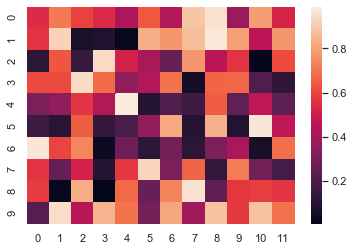

In [3]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(uniform_data)